# **Digital low pass filter**
### Laboratory of Advanced Electronics

*Marzia Faedda*

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

We initialize the sampling frequency $f_s$ at a fixed value of 100 kHz and the (discrete) time vector.

Then, the user is asked to provide the desired **cut-off frequency $f_c$**, which must comply with the constraint $$f_c << f_s $$ *i.e.* $ \tau >> T$, where $\tau$ and T are linked to these frequencies as:
$$\tau = 1/2\pi f_c$$
$$T = 1/f_s$$

To impose the "<<" requirement, we fix an arbitrary limit frequency $f_{lim} = fs/(3\pi)$, corresponding to $ \tau = 1.5 T$.  
The request is iterated until the requirement is satisfied.

In [15]:
# sample rate fixed at 100 kHz (10e5 Hz)
fs = 100000.0
# duration in seconds
t = 1.0
# time vector
t = np.arange(0, 1, 1/fs)


f_lim = fs/(3*np.pi)

def insert_cutoff_frequency():

    fc = float(input("Please enter the cutoff frequency (Hz): "))  # Ask user for cut-off frequency
    
    # Check that T << tau by checking that fc << fs
    while fc >= f_lim :
        print("Error: The condition T << tau is not met.")
        print("Please choose a cut-off frequency <= 10600 Hz")
        fc = float(input("Please enter the cutoff frequency (Hz): "))
    
    return fc

fc = insert_cutoff_frequency()
print(f"The cut-off frequency inserted is {fc} Hz ")

The cut-off frequency inserted is 1000.0 Hz 


We generate an input signal x[n] composed of 7 sine waves with random frequencies and amplitudes. The frequencies are chosen within the Nyquist boundary limit.

In [16]:
np.random.seed(0)  # For reproducibility
x = np.zeros_like(t)
for _ in range(7):
    frequency = np.random.uniform(1, fs/2)  # Frequency within Nyquist limit
    amplitude = np.random.uniform(0.01, 1)   # Amplitude between 0.5 and 5
    x += amplitude * np.sin(2 * np.pi * frequency * t)

We build the digital low pass filter response by defining its recursive difference equation:
$$ y[n] = a \cdot y[n-1] + b \cdot (x[n] + x[n-1])$$
where the coefficients *a* and *b* are dependent on the sampling period T and the circuit time constant $\tau = RC$ as:

$$ a = \frac{1 - \frac{T}{2\tau}}{1 + \frac{T}{2\tau}}$$
$$ b = \frac{\frac{T}{2\tau}}{1 + \frac{T}{2\tau}}$$

We provide at this point of the code the relation between the frequencies and the time parameters.

By construction of the signal, we have that `x[n] = 0` whenever $n < 0$, therefore this filter is causal.

In [17]:
def low_pass_filter(x, a, b):
    y = [0] * len(x)
    for n in range(1, len(x)):
        y[n] = a * y[n - 1] + b * (x[n] + x[n - 1])
    return np.array(y)

def get_filter_constants(fs, fco):
    T = 1/fs
    tau = 1/(2*np.pi*fco)
    a = (1 - T/(2*tau))/(1 + T/(2*tau))
    b = (T/(2*tau))/(1 + T/(2*tau))
    return a, b


a, b = get_filter_constants(fs, fc)
filtered_signal = low_pass_filter(x, a, b)

We plot here the representation in time of the filter's input (`x[n]`) and output (`y[n]`) signals for a comparison. These are respectively called "original" and "filtered" signal.

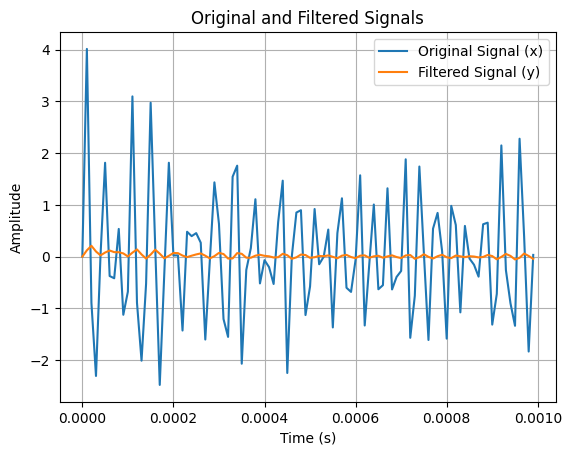

In [18]:
timelimit = t <  0.001
plt.plot(t[timelimit], x[timelimit], label='Original Signal (x)')
plt.plot(t[timelimit], filtered_signal[timelimit], label='Filtered Signal (y)')
plt.title('Original and Filtered Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Finally, we build the amplitude and phase Bode plots of the filter.
The transfer function of this low pass filter is:
$$H(z) = \frac{X(z)}{Y(z)}$$

where the numerator X(z) and denominator Y(z) were obtained through the z-transform of the difference equation, giving:
$$ X(z) = b + b \cdot z^{-1}$$
$$ Y(z) = 1 - a \cdot z^{-1}$$

To evaluate the **frequency response** ${\tilde{H}}(\omega)$ we must apply the backward interpretation of the simulation theorem and evaluate the transfer function in:
$$ {\tilde{H}}(z = e^{-i\omega T})$$

To do this, we use the function `signal.freqz`.

In [21]:
# plot bode diagram
# Define numerator and denominator
numerator = [b, b]
denominator = [1, -a]

w_lim = 2*np.pi*f_lim

# Compute frequency response
w, h = signal.freqz(numerator, denominator, worN=np.linspace(0, f_lim, 1000), fs=fs)
w *= 2*np.pi


In the following block we plot the Bode diagrams of amplitude and phase representing the frequency response of our digital low pass filter.

The cut-off frequency is highlited in red and corresponds to a decrease in the amplitude of -3 dB and to a phase shift of -45 degrees.

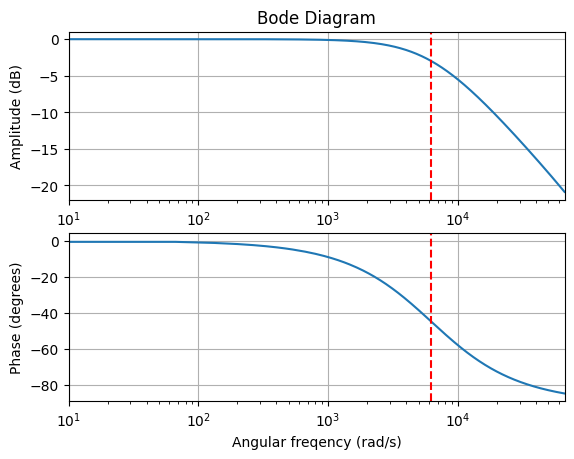

In [25]:
# Plot the magnitude response
plt.subplot(2, 1, 1)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Bode Diagram')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.xlim([10, w_lim])  # Set x-axis limits
plt.axvline(x=2*np.pi*fc, color='r', linestyle='--') # Highlight the cutoff frequency
#plt.annotate(f'Cutoff: {fc} Hz', xy=(fc, -3), xytext=(fc, -20), arrowprops=dict(facecolor='black', arrowstyle='->'))
# Plot the phase response
plt.subplot(2, 1, 2)
plt.semilogx(w, np.angle(h)/np.pi*180.0)
plt.ylabel('Phase (degrees)')
plt.grid(True)
plt.xlabel('Angular freqency (rad/s)')
plt.xlim([10, w_lim])  # Set x-axis limits
plt.axvline(x=2*np.pi*fc, color='r', linestyle='--') # Highlight the cutoff frequency
#plt.annotate(f'Cutoff: {fc} Hz', xy=(fc, -3), xytext=(fc, -20), arrowprops=dict(facecolor='black', arrowstyle='->'))
#plt.tight_layout()
plt.show()
